# Neural Style Transfer
## Divyansh Diwakar (22112035)

In [5]:
!pip3 install cython
!pip3 install tensornets



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 651.1/651.1 kB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tensornets: filename=tensornets-0.4.6-cp310-cp310-linux_x86_64.whl size=1495647 sha256=030e55aa13b75f67aa41e1f7b8da283bbf64f46e616b5ea72a22e6a5c5f74b71
  Stored in directory: /root/.cache/pip/wheels/01/a5/1c/0b56f70e458ba833b02ed125cf5c5c9240175cbd9fe7af66c8
Successfully built tensornets


In [6]:
!pip install ipywidgets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.1 MB/s eta 0:00:00


# Importing Necessary Modules

Lets start by importing all necessary modules:

- `numpy` : for arrays manipulation
- `tensorflow` : for tensor operations
- `tensorflow.keras` : high level neural network library for tensorflow for creating neural networks
- `pillow` : for converting an image to numpy array and numpy array to image, saving out output image.
- `time` : for calculating time of each iteration
- `matplotlib` : for displaying images and graphs in notebook
- `request`, `base64`, `io` : for downloading and loading image from url
- `os` : operating system level commands

In [7]:
import tensorflow as tf  # Import TensorFlow library for deep learning operations
from tensorflow.keras.applications import VGG19  # Import VGG19 pre-trained model for feature extraction
from tensorflow.keras.models import Model  # Import Model class to create custom models
from tensorflow.keras.optimizers import Adam  # Import Adam optimizer for gradient descent
from tensorflow.keras.preprocessing import image as kp_image  # Import image module for image processing
import numpy as np  # Import NumPy library for numerical operations
from PIL import Image  # Import Image module from PIL for image handling
import matplotlib.pyplot as plt  # Import matplotlib for plotting
import ipywidgets as widgets  # Import ipywidgets for interactive widgets
from IPython.display import display, clear_output  # Import display and clear_output for notebook display management



In [8]:
# Ensure TensorFlow is running in eager mode
tf.config.run_functions_eagerly(True)

# Define Utility Functions

The below function is used to load image from path specified.

In [9]:
def load_img(path):
    input_size = (224, 224)
    img = Image.open(path)
    img = img.resize(input_size, Image.ANTIALIAS)
    img = np.array(img)[...,:3]
    img = img.astype('float32')
    return img

Function to load and preprocess the image

In [10]:


def load_and_process_img(path_to_img):
    img = load_img(path_to_img)
    img[:, :, 0] -= 103.939
    img[:, :, 1] -= 116.779
    img[:, :, 2] -= 123.68
    img = img[:, :, ::-1]
    img = np.expand_dims(img, axis=0)
    return img


Function to deprocess the image back to the original form

In [11]:

def deprocess_img(processed_img):
    x = processed_img.copy() #Processed image tensor.
    if len(x.shape) == 4:

#Deprocessed image array.
          x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# # Loading VGG19 model

VGG19 is a convolutional neural network architecture known for its deep layers and straightforward design.

Architecture: It consists of 19 layers, with 16 convolutional and 3 fully connected layers.
Layers: Each convolutional layer uses 3x3 filters and is followed by max-pooling with 2x2 filters.
Activation: ReLU activation functions are applied throughout the network.
Performance: Despite its simplicity, VGG19 has shown strong performance on image classification tasks.

In [12]:
# Load VGG19 model pre-trained on ImageNet
vgg = VGG19(weights='imagenet', include_top=False)


80134624/80134624 [==============================] - 0s 0us/step


 Define the model to output content and style layer activations

In [13]:

content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]
output_layers = style_layers + content_layers
model_outputs = [vgg.get_layer(name).output for name in output_layers]
model = Model(inputs=vgg.input, outputs=model_outputs)


# get_feature_representations function

The get_feature_representations function does two main things: first, it prepares the style and content images by getting them ready for a deep learning model like VGG19. Then, it figures out which parts of the model light up the most when you look at these images. These "features" help the computer understand things like textures and details. These features are really important because they help the computer figure out how to mix the style of one image with the content of another to create a new image that looks cool and unique.

In [14]:
def get_feature_representations(model, content_path, style_path):
    # Load and process the content and style images
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

   # Compute content and style features
    style_outputs = model(style_image)      # Get model outputs for style image
    content_outputs = model(content_image)  # Get model outputs for content image

    # Separate style and content features from model outputs
    style_features = [style_layer for style_layer in style_outputs[:len(style_layers)]]  # Extract style features
    content_features = [content_layer for content_layer in content_outputs[len(style_layers):]]  # Extract content features

    return style_features, content_features

# compute_gram_matrix function

The compute_gram_matrix function transforms an input tensor into a Gram matrix, which summarizes the correlations between different channels of the tensor. It reshapes the tensor to combine spatial dimensions, computes correlations using matrix multiplication with its transpose, and then normalizes the matrix. This Gram matrix is essential in style transfer tasks to capture the texture and style characteristics of an image.

In [15]:
def compute_gram_matrix(input_tensor):
    # Compute the Gram matrix

    # Get the number of channels in the input tensor
    channels = int(input_tensor.shape[-1])

    # Reshape the input tensor to combine spatial dimensions into a single dimension
    a = tf.reshape(input_tensor, [-1, channels])

    # Get the number of elements in the reshaped tensor (which corresponds to 'n' in the Gram matrix formula)
    n = tf.shape(a)[0]

    # Compute the Gram matrix by matrix multiplication of reshaped tensor with its transpose
    gram = tf.matmul(a, a, transpose_a=True)

    # Normalize the Gram matrix by dividing by the number of elements 'n'
    gram = gram / tf.cast(n, tf.float32)

    return gram


# get_style_loss function

The get_style_loss function computes the style loss, which quantifies how much the style of a generated image differs from a reference style image. It initializes a variable style_loss to accumulate the loss. It calculates the weight_per_style_layer, which divides the style loss evenly across all style layers considered.

In [16]:
def get_style_loss(style_features, style_outputs):
    style_loss = 0  # Initialize style loss accumulator

    # Calculate weight per style layer
    weight_per_style_layer = 1.0 / float(len(style_layers))

    # Iterate through style features and style outputs
    for style_feature, style_output in zip(style_features, style_outputs):
        # Compute Gram matrices for style feature and style output
        gram_style = compute_gram_matrix(style_feature)
        gram_output = compute_gram_matrix(style_output)

        # Calculate mean squared error between Gram matrices and accumulate style loss
        style_loss += weight_per_style_layer * tf.reduce_mean(tf.square(gram_style - gram_output))

    return style_loss  # Return accumulated style loss


#  get_content_loss function

The get_content_loss function calculates the content loss, which measures how much the content of a generated image differs from a reference content image. It computes the mean squared error (MSE) between the content_feature, representing the content of the reference image, and content_output, which is the corresponding content representation of the generated image. This loss helps ensure that the generated image preserves the essential details and structures found in the original content image.

In [17]:
def get_content_loss(content_feature, content_output):
    # Compute the mean squared error between content feature and content output
    return tf.reduce_mean(tf.square(content_feature - content_output))

def get_total_loss(model, loss_weights, init_image, gram_style_features, content_feature):
    style_weight, content_weight = loss_weights

    # Get model outputs for the initialized image
    model_outputs = model(init_image)

    # Separate style and content output features
    style_output_features = model_outputs[:len(style_layers)]
    content_output_feature = model_outputs[len(style_layers):]

    # Calculate style and content losses
    style_score = get_style_loss(gram_style_features, style_output_features)
    content_score = get_content_loss(content_feature, content_output_feature[0])

    # Scale losses by their respective weights
    style_score *= style_weight
    content_score *= content_weight

    # Calculate total loss as a combination of style and content losses
    loss = style_score + content_score

    return loss, style_score, content_score



In [18]:
upload_content = widgets.FileUpload(accept='image/*', multiple=False)
upload_style = widgets.FileUpload(accept='image/*', multiple=False)

def on_upload_change(change):
    global content_img, style_img, content_path, style_path

    if upload_content.value and upload_style.value:
        content_file = list(upload_content.value.values())[0]
        style_file = list(upload_style.value.values())[0]

        content_path = 'uploaded_content.jpg'
        style_path = 'uploaded_style.jpg'

        with open(content_path, 'wb') as f:
            f.write(content_file['content'])

        with open(style_path, 'wb') as f:
            f.write(style_file['content'])

        content_img = load_and_process_img(content_path)
        style_img = load_and_process_img(style_path)

        display_images(content_path, style_path)

        # Proceed with style transfer
        perform_style_transfer()

# display_images function

The display_images function provides a straightforward way to visually inspect and compare the content and style images used in a style transfer or similar image processing task. It utilizes matplotlib (plt) for plotting and PIL (Image.open) for image loading, ensuring that the images are displayed clearly and labeled appropriately within a notebook environment. This function is essential for understanding the input images before and after applying style transfer algorithms or other image processing techniques.

In [19]:
def display_images(content_path, style_path):
    # Clear any previous output and display images side by side
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with two subplots

    # Open and display the content image
    content_image = Image.open(content_path)
    style_image = Image.open(style_path)

    ax[0].imshow(content_image)  # Display content image in the first subplot
    ax[0].set_title('Content Image')  # Set title for the first subplot

    ax[1].imshow(style_image)  # Display style image in the second subplot
    ax[1].set_title('Style Image')  # Set title for the second subplot

    plt.show()  # Display the entire figure containing both subplots


#  perform_style_transfer function

The perform_style_transfer function modifies an initial image (init_image) to blend the artistic style of one picture with the content of another. It uses a model to analyze the style and content features of these images. Through multiple rounds of adjustments, it fine-tunes the image to match the desired style and content more closely. Finally, it displays the resulting image, showing how the style and content have merged.



In [20]:
def perform_style_transfer():
    # Get style and content features from the images
    style_features, content_features = get_feature_representations(model, content_path, style_path)

    # Initialize the generated image as a variable with the content image
    init_image = tf.Variable(content_img, dtype=tf.float32)

    # Define the optimizer (Adam optimizer with a high learning rate for style transfer)
    opt = Adam(learning_rate=10.0)

    # Training parameters
    epochs = 10
    steps_per_epoch = 100

    # Loss weights for style and content
    style_weight = 1e-2
    content_weight = 1e3
    loss_weights = (style_weight, content_weight)

    # Initialize list to store losses for each epoch
    epoch_losses = []

    # Training loop
    for epoch in range(epochs):
        for step in range(steps_per_epoch):
            # Compute the total loss and gradients using backpropagation
            with tf.GradientTape() as tape:
                all_loss = get_total_loss(model, loss_weights, init_image, style_features, content_features[0])

            total_loss = all_loss[0]
            grad = tape.gradient(total_loss, init_image)
            opt.apply_gradients([(grad, init_image)])

            # Print loss every 10 steps
            if step % 10 == 0:
                print(f"Epoch {epoch}, Step {step}, Loss: {total_loss}")

        # Append the total loss of the current epoch to the list
        epoch_losses.append(total_loss.numpy())

    # Convert the final generated image from tensor to numpy array and display it
    final_img = deprocess_img(init_image.numpy())
    plt.imshow(final_img)
    plt.axis('off')  # Turn off axis for cleaner display
    plt.show()

    # Plotting epoch vs. loss
    plt.figure()
    plt.plot(range(epochs), epoch_losses, 'r')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch vs. Loss')
    plt.show()



#load_and_process_img to load and preprocess the uploaded images





In [21]:
upload_content.observe(on_upload_change, names='value')
upload_style.observe(on_upload_change, names='value')

# Display

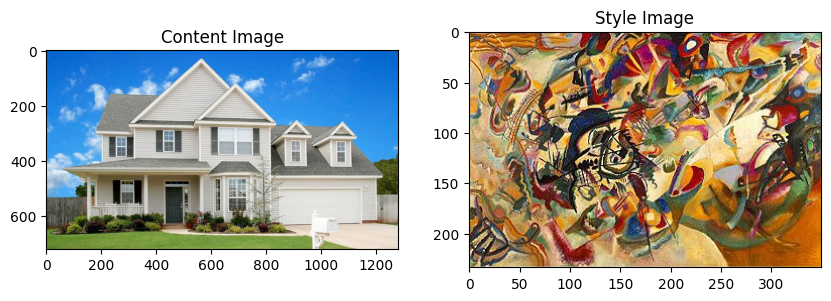

Epoch 0, Step 0, Loss: 1616034176.0
Epoch 0, Step 10, Loss: 104650992.0
Epoch 0, Step 20, Loss: 48304512.0
Epoch 0, Step 30, Loss: 31859524.0
Epoch 0, Step 40, Loss: 23806330.0
Epoch 0, Step 50, Loss: 19116850.0
Epoch 0, Step 60, Loss: 16241571.0
Epoch 0, Step 70, Loss: 14344160.0
Epoch 0, Step 80, Loss: 13020730.0
Epoch 0, Step 90, Loss: 12042274.0
Epoch 1, Step 0, Loss: 11282187.0
Epoch 1, Step 10, Loss: 10672522.0
Epoch 1, Step 20, Loss: 10665581.0
Epoch 1, Step 30, Loss: 10147478.0
Epoch 1, Step 40, Loss: 9853958.0
Epoch 1, Step 50, Loss: 9326054.0
Epoch 1, Step 60, Loss: 8914194.0
Epoch 1, Step 70, Loss: 8672198.0
Epoch 1, Step 80, Loss: 8545041.0
Epoch 1, Step 90, Loss: 8234846.5
Epoch 2, Step 0, Loss: 8225398.0
Epoch 2, Step 10, Loss: 7907763.5
Epoch 2, Step 20, Loss: 7911813.0
Epoch 2, Step 30, Loss: 8211967.0
Epoch 2, Step 40, Loss: 8028173.0
Epoch 2, Step 50, Loss: 7486489.0
Epoch 2, Step 60, Loss: 7432245.0
Epoch 2, Step 70, Loss: 7234711.0
Epoch 2, Step 80, Loss: 7253978.5


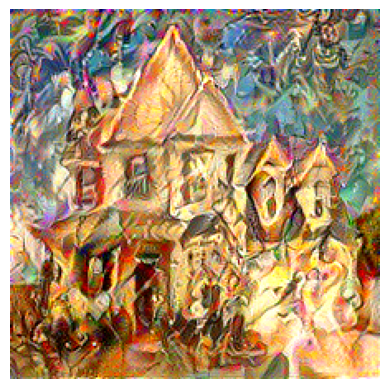

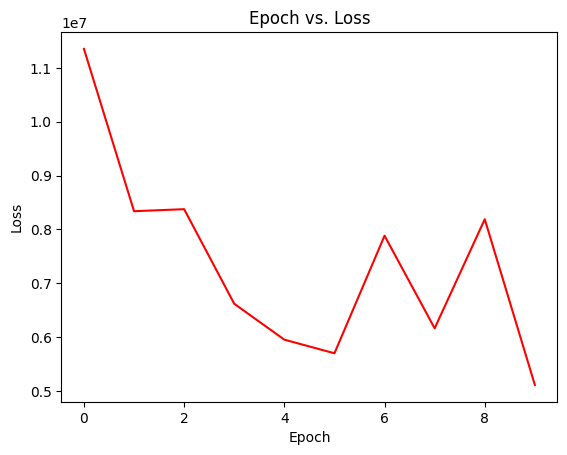

In [22]:


display(widgets.VBox([widgets.Label("Upload Content Image"), upload_content,
                      widgets.Label("Upload Style Image"), upload_style]))